# Determine period size for benchmark datasets

This notebook iterates over all datasets in our benchmark dataset collection and determines the dominant period size using [`forecast.findfrequency`](https://rdrr.io/cran/forecast/man/findfrequency.html) from R.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import rpy2

from pathlib import Path

plt.rcParams["figure.figsize"] = (20, 8)

Prepare notebooks for R usage

In [2]:
import os
os.environ["R_HOME"] = "/home/sebastian.schmidl/.conda/envs/python-r/lib/R"

Load R libraries (install `forecast` if not present)

In [3]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
try:
    from rpy2.rinterface import RRuntimeError
except ImportError:
    from rpy2.rinterface.embedded import RRuntimeError

try:
    forecast = importr("forecast")
except ImportError:
    utils = importr("utils")
    utils.chooseCRANmirror(ind=1)
    utils.install_packages(robjects.StrVector(["forecast"]))
    forecast = importr("forecast")

/home/sebastian.schmidl/.conda/envs/python-r/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/home/sebastian.schmidl/.conda/envs/python-r/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/home/sebastian.schmidl/.conda/envs/python-r/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/home/sebastian.schmidl/.conda/envs/python-r/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2: Setting LC_MONETARY failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/home/sebastian.schmidl/.conda/envs/python-r/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 3: Setting LC_PAPER failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/home/sebastian.schmidl/.conda/envs/python-r/l

## Iterate over datasets and determine their period

Load dataset overview file

In [12]:
root_path = Path("/home/projects/akita/data/benchmark-data/data-processed")
df_datasets = pd.read_csv(root_path / "datasets.csv")
df_datasets

,collection_name,dataset_name,train_path,test_path,dataset_type,datetime_index,split_at,train_type,train_is_normal,input_type,...,contamination,num_anomalies,min_anomaly_length,median_anomaly_length,max_anomaly_length,mean,stddev,trend,stationarity,period_size
0,CalIt2,CalIt2-traffic,NaN,multivariate/CalIt2/CalIt2-traffic.test.csv,real,True,NaN,unsupervised,False,multivariate,...,0.040873,29,2,7,19,3.812897,6.422468,no trend,difference_stationary,48.0
1,Daphnet,S01R01E0,NaN,multivariate/Daphnet/S01R01E0.test.csv,real,True,NaN,unsupervised,False,multivariate,...,0.000000,0,0,0,0,365.860382,263.588317,no trend,difference_stationary,36.0
2,Daphnet,S01R01E1,NaN,multivariate/Daphnet/S01R01E1.test.csv,real,True,NaN,unsupervised,False,multivariate,...,0.069932,18,34,127,973,388.778434,318.691519,no trend,stationary,32.0
3,Daphnet,S01R02E0,NaN,multivariate/Daphnet/S01R02E0.test.csv,real,True,NaN,unsupervised,False,multivariate,...,0.053715,5,112,256,571,368.768492,318.540618,no trend,stationary,34.0
4,Daphnet,S02R01E0,NaN,multivariate/Daphnet/S02R01E0.test.csv,real,True,NaN,unsupervised,False,multivariate,...,0.138164,9,60,440,911,357.262886,401.863439,no trend,stationary,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,WebscopeS5,A4Benchmark-95,NaN,univariate/WebscopeS5/A4Benchmark-95.test.csv,synthetic,True,NaN,unsupervised,False,univariate,...,0.004762,8,1,1,1,1682.450826,1000.344063,linear trend,trend_stationary,12.0
1165,WebscopeS5,A4Benchmark-96,NaN,univariate/WebscopeS5/A4Benchmark-96.test.csv,synthetic,True,NaN,unsupervised,False,univariate,...,0.002976,5,1,1,1,1992.507175,1073.141772,linear trend,trend_stationary,12.0
1166,WebscopeS5,A4Benchmark-97,NaN,univariate/WebscopeS5/A4Benchmark-97.test.csv,synthetic,True,NaN,unsupervised,False,univariate,...,0.010119,17,1,1,1,-633.574096,863.324620,kubic trend,trend_stationary,12.0
1167,WebscopeS5,A4Benchmark-98,NaN,univariate/WebscopeS5/A4Benchmark-98.test.csv,synthetic,True,NaN,unsupervised,False,univariate,...,0.010119,17,1,1,1,2468.960650,1400.068899,kubic trend,trend_stationary,12.0


Perform period size extraction and store it in the metadata files and the dataset overview

In [13]:
def find_frequency(values):
    try:
        x = robjects.FloatVector(values.tolist())
        return forecast.findfrequency(x)[0]
    except RRuntimeError as ex:
        if "zero-variance series" in str(ex) or "'order.max' must be >= 1" in str(ex) or "Error in lm.fit" in str(ex):
            return 1
        else:
            raise ex

def get_metadata_filename(dataset_path):
    filename_base = ".".join(dataset_path.stem.split(".")[:-1])
    return dataset_path.parent / f"{filename_base}.metadata.json"

def find_periods(dataset_path):
    df = pd.read_csv(dataset_path, parse_dates=True, infer_datetime_format=True)
    periods = []
    features = set(df.columns) - {"timestamp", "is_anomaly"}
    for f in features:
        period = find_frequency(df[f])
        periods.append(period)
    periods = [int(p) for p in periods]
    return list(zip(features, periods))

def aggregate_periods(periods):
    periods = np.array([p for (f, p) in periods])
    hist = np.bincount(periods)
    mode = hist.argmax()
    if hist[mode] < 2:
        mode = np.median(periods)
    return int(mode)

In [14]:
def process_dataset(dataset_path, metas, is_train = False):
    periods = find_periods(dataset_path)
    print(f"  ... {'train' if is_train else 'test'} dataset: {[p for (f, p) in periods]}")
    for meta in metas:
        if meta["is_train"] == is_train:
            meta["periods"] = dict(periods)
    if is_train == False:
        return aggregate_periods(periods)
    else:
        return None

current_collection = None
selected_collection = "NormA"
for i, row in df_datasets.iterrows():
    if selected_collection is not None and row["collection_name"] != selected_collection:
        continue
    if not np.isnan(row["period_size"]):
        print(f"Skipping {row['collection_name']}/{row['dataset_name']}, because it already has a period ({row['period_size']})")
        continue
    if row["collection_name"] == "Kitsune":
        print(f"Skipping {row['collection_name']}/{row['dataset_name']}, because it would take too long!")
        continue
    
    if current_collection != row["collection_name"]:
        # store dataset overview
        print("### Saving dataset overview!")
        df_datasets.to_csv(root_path / "datasets.csv", index=False)
    current_collection = row["collection_name"]

    print(f"Processing {row['collection_name']}/{row['dataset_name']} ...")
    dataset_path = root_path / row["test_path"]
    # load metadata
    meta_filename = get_metadata_filename(dataset_path)
    try:
        with meta_filename.open("r") as fh:
            metas = json.load(fh)
        skip_meta = False
    except FileNotFoundError:
        print("  ... skipping metadata files!")
        skip_meta = True
        metas = []
        
    # for test dataset
    period = process_dataset(dataset_path, metas, is_train=False)
    
    # for train dataset (if exist)
    if row["train_type"] != "unsupervised" and not skip_meta:
        dataset_path = root_path / row["train_path"]
        process_dataset(dataset_path, metas, is_train=True)
    
    print(f"  ... period = {period}")
    
    # store metadata
    if not skip_meta:
        print("  ... writing metadata file")
        with meta_filename.open("w") as fh:
            json.dump(metas, fh, indent=2, sort_keys=True)

    # adapt dataset overview
    df_datasets.loc[i, "period_size"] = period
    print("finished.")

# store dataset overview
print("\nSaving dataset overview!")
df_datasets.to_csv(root_path / "datasets.csv", index=False)

### Saving dataset overview!
Processing NormA/Discords_annsgun ...
  ... test dataset: [111]
  ... period = 111
  ... writing metadata file
finished.
Processing NormA/Discords_dutch_power_demand ...
  ... test dataset: [111]
  ... period = 111
  ... writing metadata file
finished.
Processing NormA/Discords_marotta_valve_tek_14 ...
  ... test dataset: [1]
  ... period = 1
  ... writing metadata file
finished.
Processing NormA/Discords_marotta_valve_tek_16 ...
  ... test dataset: [1]
  ... period = 1
  ... writing metadata file
finished.
Processing NormA/Discords_marotta_valve_tek_17 ...
  ... test dataset: [1]
  ... period = 1
  ... writing metadata file
finished.
Processing NormA/Discords_patient_respiration1 ...
  ... test dataset: [22]
  ... period = 22
  ... writing metadata file
finished.
Processing NormA/Discords_patient_respiration2 ...
  ... test dataset: [40]
  ... period = 40
  ... writing metadata file
finished.
Processing NormA/SinusRW_Length_104000_AnomalyL_200_AnomalyN_20_

Replace periods of size `1` with `NaN` (because then our fallback values come into play).

In [15]:
root_path = Path("/home/projects/akita/data/benchmark-data/data-processed")
df_datasets = pd.read_csv(root_path / "datasets.csv")

indexer = df_datasets["period_size"] == 1
df_datasets.loc[indexer, "period_size"] = np.nan

df_datasets.to_csv(root_path / "datasets.csv", index=False)

In [16]:
df_datasets[df_datasets["collection_name"] == "NormA"]

,collection_name,dataset_name,train_path,test_path,dataset_type,datetime_index,split_at,train_type,train_is_normal,input_type,...,contamination,num_anomalies,min_anomaly_length,median_anomaly_length,max_anomaly_length,mean,stddev,trend,stationarity,period_size
621,NormA,Discords_annsgun,NaN,univariate/NormA/Discords_annsgun.test.csv,real,False,NaN,unsupervised,False,univariate,...,0.075000,1,150,150,150,3.097742e+02,96.244237,no trend,difference_stationary,111.0
622,NormA,Discords_dutch_power_demand,NaN,univariate/NormA/Discords_dutch_power_demand.t...,real,False,NaN,unsupervised,False,univariate,...,0.091324,4,800,800,800,1.144038e+03,292.725791,no trend,stationary,111.0
623,NormA,Discords_marotta_valve_tek_14,NaN,univariate/NormA/Discords_marotta_valve_tek_14...,real,False,NaN,unsupervised,False,univariate,...,0.051200,2,128,128,128,1.120064e+00,1.703123,no trend,difference_stationary,NaN
624,NormA,Discords_marotta_valve_tek_16,NaN,univariate/NormA/Discords_marotta_valve_tek_16...,real,False,NaN,unsupervised,False,univariate,...,0.025600,1,128,128,128,1.054768e+00,1.665258,no trend,difference_stationary,NaN
625,NormA,Discords_marotta_valve_tek_17,NaN,univariate/NormA/Discords_marotta_valve_tek_17...,real,False,NaN,unsupervised,False,univariate,...,0.025600,1,128,128,128,9.959120e-01,1.626007,no trend,difference_stationary,NaN
626,NormA,Discords_patient_respiration1,NaN,univariate/NormA/Discords_patient_respiration1...,real,False,NaN,unsupervised,False,univariate,...,0.030769,2,100,100,100,7.452095e+01,289.473775,no trend,stationary,22.0
627,NormA,Discords_patient_respiration2,NaN,univariate/NormA/Discords_patient_respiration2...,real,False,NaN,unsupervised,False,univariate,...,0.075000,2,150,150,150,7.977460e+01,77.999132,no trend,stationary,40.0
628,NormA,SinusRW_Length_104000_AnomalyL_200_AnomalyN_20...,NaN,univariate/NormA/SinusRW_Length_104000_Anomaly...,synthetic,False,NaN,unsupervised,False,univariate,...,0.038462,20,200,200,200,-6.943642e-15,1.413004,no trend,stationary,250.0
629,NormA,SinusRW_Length_106000_AnomalyL_100_AnomalyN_60...,NaN,univariate/NormA/SinusRW_Length_106000_Anomaly...,synthetic,False,NaN,unsupervised,False,univariate,...,0.056604,60,100,100,100,-5.439808e-15,1.414737,no trend,stationary,250.0
630,NormA,SinusRW_Length_108000_AnomalyL_200_AnomalyN_40...,NaN,univariate/NormA/SinusRW_Length_108000_Anomaly...,synthetic,False,NaN,unsupervised,False,univariate,...,0.074074,40,200,200,200,-1.370558e-15,1.412455,no trend,stationary,250.0


## Experimentation

In [8]:
dataset_path = root_path / df_datasets.loc[1, "test_path"]
df = pd.read_csv(dataset_path, parse_dates=True, infer_datetime_format=True)
df

,timestamp,ankle_horiz_fwd,ankle_vert,ankle_horiz_lateral,leg_horiz_fwd,leg_vert,leg_horiz_lateral,trunk_horiz_fwd,trunk_vert,trunk_horiz_lateral,is_anomaly
0,1970-01-01 00:12:30.000,-30,990,326,-45,972,181,-38,1000,29,0
1,1970-01-01 00:12:30.015,-30,1000,356,-18,981,212,-48,1028,29,0
2,1970-01-01 00:12:30.031,-20,990,336,18,981,222,-38,1038,9,0
3,1970-01-01 00:12:30.046,-20,1000,316,36,990,222,-19,1038,9,0
4,1970-01-01 00:12:30.062,0,990,316,36,990,212,-29,1038,29,0
...,...,...,...,...,...,...,...,...,...,...,...
19195,1970-01-01 00:17:29.921,-353,960,237,145,962,181,-77,1000,-19,0
19196,1970-01-01 00:17:29.937,-323,960,297,54,981,202,-58,980,-9,0
19197,1970-01-01 00:17:29.953,-303,960,287,0,1046,222,-58,961,19,0
19198,1970-01-01 00:17:29.968,-272,980,297,-172,990,191,-58,971,-9,0


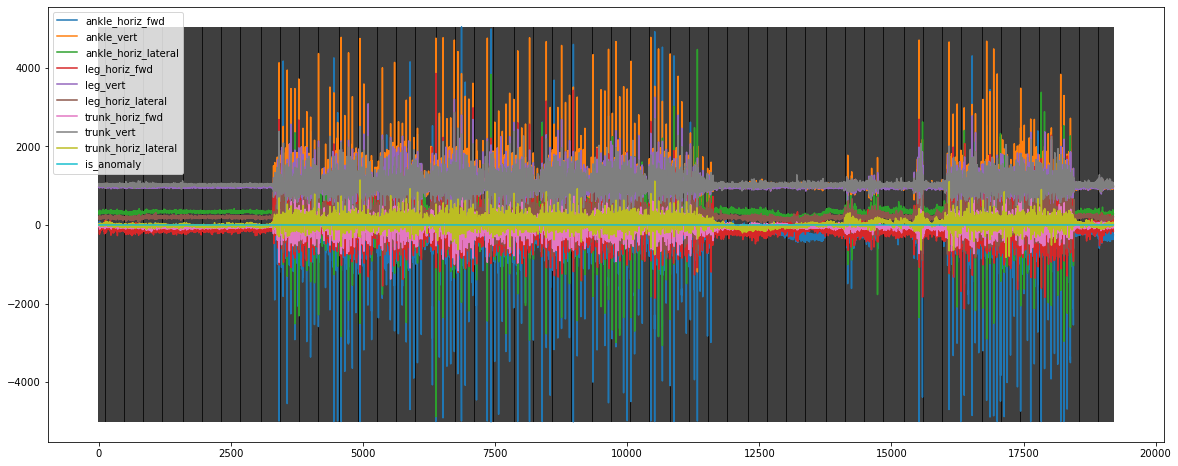

In [9]:
periods = find_periods(dataset_path)
period = aggregate_periods(periods)
df.plot()
indices = np.arange(0, df.shape[0], period)
plt.vlines(indices, df.min(axis=1).min()-5, df.max(axis=1).max()+5, color="black")
plt.show()

In [11]:
meta_filename = get_metadata_filename(root_path / df_datasets.loc[1, "test_path"])
with meta_filename.open("r") as fh:
    metas = json.load(fh)
metas
for meta in metas:
    if meta["is_train"] == False:
        meta["periods"] = dict(periods)
metas

[{'anomaly_length': {'max': 0, 'median': 0, 'min': 0},
  'contamination': 0.0,
  'dataset_id': ['Daphnet', 'S01R01E0'],
  'dimensions': 9,
  'is_train': False,
  'length': 19200,
  'means': {'ankle_horiz_fwd': -237.45979166666666,
   'ankle_horiz_lateral': 335.3857291666667,
   'ankle_vert': 988.5178125,
   'leg_horiz_fwd': -44.54505208333333,
   'leg_horiz_lateral': 212.06390625,
   'leg_vert': 986.2916145833333,
   'trunk_horiz_fwd': -25.295364583333335,
   'trunk_horiz_lateral': 63.12739583333333,
   'trunk_vert': 1014.6571875},
  'num_anomalies': 0,
  'periods': {'trunk_vert': 18,
   'trunk_horiz_lateral': 36,
   'leg_horiz_fwd': 36,
   'ankle_horiz_lateral': 23,
   'ankle_horiz_fwd': 59,
   'leg_vert': 34,
   'leg_horiz_lateral': 10,
   'ankle_vert': 36,
   'trunk_horiz_fwd': 14},
  'stationarities': {'ankle_horiz_fwd': 'stationary',
   'ankle_horiz_lateral': 'stationary',
   'ankle_vert': 'stationary',
   'leg_horiz_fwd': 'stationary',
   'leg_horiz_lateral': 'stationary',
   'le

In [12]:
periods = np.array(periods)
print(f"min={periods.min()},median={np.median(periods)},max={periods.max()},lcm={np.lcm.reduce(periods)},gcd={np.gcd.reduce(periods)},mode={np.bincount(periods).argmax()}")
aggregate_periods(periods)

TypeError: cannot perform reduce with flexible type